Final Policy Probabilities: [0.01470092 0.02636775 0.95893133]


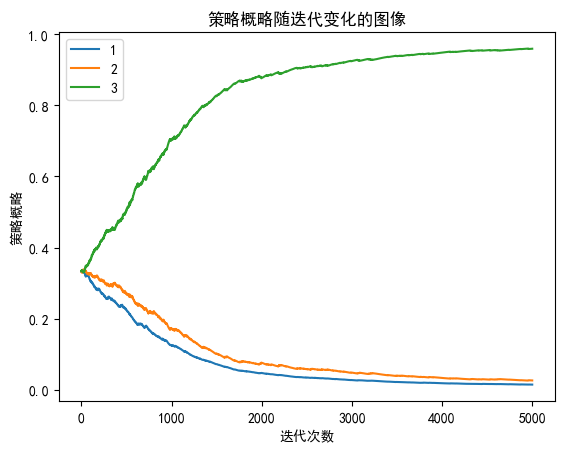

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

# 设置随机种子
np.random.seed(42)

# 环境：3个拉杆，每个拉杆的真实奖励概率
true_action_probs = [0.2, 0.5, 0.8]

# 策略参数初始化
theta = np.array([0.0, 0.0, 0.0])  # 初始参数
learning_rate = 0.01  # 学习率

# Softmax 策略
def softmax(theta):
    exp_theta = np.exp(theta - np.max(theta))  # 防止溢出
    return exp_theta / np.sum(exp_theta)

# 采样动作
def sample_action(probs):
    return np.random.choice(len(probs), p=probs)

# 环境交互：执行动作，获得奖励
def get_reward(action):
    return np.random.rand() < true_action_probs[action]  # Bernoulli 分布

# REINFORCE算法训练
num_episodes = 5000

# 存储每次迭代的策略概略
policy_probs = []

for episode in range(num_episodes):
    # 1. 计算策略
    action_probs = softmax(theta)
    
    # 存储当前策略概略
    policy_probs.append(action_probs)
    
    # 2. 采样动作
    action = sample_action(action_probs)
    
    # 3. 执行动作，获得奖励
    reward = get_reward(action)
    
    # 4. 更新策略参数
    # 计算梯度：log概率的梯度
    grad_log_pi = -action_probs
    grad_log_pi[action] += 1  # 对应选中动作的梯度
    
    # REINFORCE 更新
    theta += learning_rate * reward * grad_log_pi

print("Final Policy Probabilities:", softmax(theta))

# 将策略概略转换为numpy数组，方便绘图
policy_probs = np.array(policy_probs)

# 绘制策略概略随迭代变化的图像
plt.plot(policy_probs)
'''for i, prob in enumerate(true_action_probs):
    plt.axhline(y=prob, color='r', linestyle='--')  # 绘制真实概率的水平线
    plt.text(i, prob, str(prob), ha='right', va='bottom')  # 在水平线上方添加标签'''
plt.xlabel('迭代次数')
plt.ylabel('策略概略')
plt.title('策略概略随迭代变化的图像')
plt.legend(['1', '2', '3'])  # 添加图例
plt.show()


Final Policy Probabilities: [0.01581819 0.02849055 0.95569126]


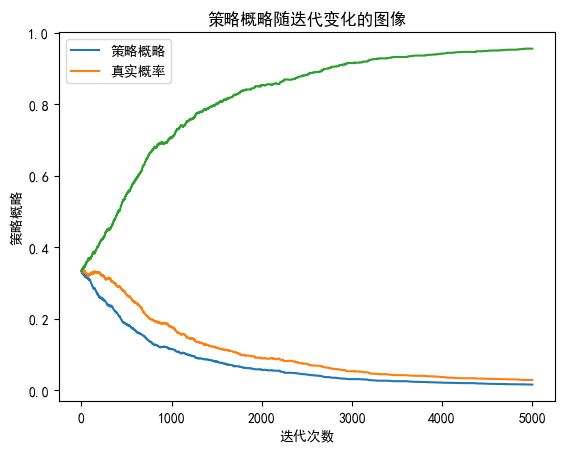

In [2]:
# 引入基线
baseline = 0.0  # 基线初始为0
alpha_baseline = 0.01  # 基线更新率
# 策略参数初始化
theta = np.array([0.0, 0.0, 0.0])  # 初始参数
learning_rate = 0.01  # 学习率

# 存储每次迭代的策略概略
policy_probs = []

for episode in range(num_episodes):
    # 1. 计算策略
    action_probs = softmax(theta)

    # 存储当前策略概略
    policy_probs.append(action_probs)
    
    # 2. 采样动作
    action = sample_action(action_probs)
    
    # 3. 执行动作，获得奖励
    reward = get_reward(action)
    
    # 4. 更新基线（使用滑动平均法）
    baseline = (1 - alpha_baseline) * baseline + alpha_baseline * reward
    
    # 5. 计算梯度：log概率的梯度
    grad_log_pi = -action_probs
    grad_log_pi[action] += 1  # 对应选中动作的梯度
    
    # REINFORCE 带基线更新
    theta += learning_rate * (reward - baseline) * grad_log_pi

    # 每100轮打印一次参数和策略
    '''if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Theta = {theta}, Policy = {softmax(theta)}")'''

print("Final Policy Probabilities:", softmax(theta))

# 将策略概略转换为numpy数组，方便绘图
policy_probs = np.array(policy_probs)

# 绘制策略概略随迭代变化的图像
plt.plot(policy_probs)
'''for i, prob in enumerate(true_action_probs):
    plt.axhline(y=prob, color='r', linestyle='--')  # 绘制真实概率的水平线
    plt.text(i, prob, str(prob), ha='right', va='bottom')  # 在水平线上方添加标签'''
plt.xlabel('迭代次数')
plt.ylabel('策略概略')
plt.title('策略概略随迭代变化的图像')
plt.legend(['策略概略', '真实概率'])  # 添加图例
plt.show()


In [4]:
from scipy.optimize import minimize

# 策略参数初始化
num_actions = len(true_action_probs)
theta = np.array([0.0, 0.0, 0.0])  # 初始参数
num_iterations = 100
delta = 0.01  # KL 散度约束的阈值

# 计算 KL 散度
def kl_divergence(old_probs, new_probs, epsilon=1e-10):
    old_probs = np.clip(old_probs, epsilon, 1.0)
    new_probs = np.clip(new_probs, epsilon, 1.0)
    return np.sum(old_probs * (np.log(old_probs) - np.log(new_probs)))


# TRPO 主循环
for iteration in range(num_iterations):
    old_probs = softmax(theta)  # 当前策略概率
    rewards = []
    actions = []
    
    # 采样当前策略下的动作和奖励
    for _ in range(100):
        action = np.random.choice(num_actions, p=old_probs)
        reward = get_reward(action)
        actions.append(action)
        rewards.append(reward)
    
    # 计算优势估计（这里直接用奖励 - 平均奖励作为优势）
    avg_reward = np.mean(rewards)
    advantages = np.array([reward - avg_reward for reward in rewards])
    
    # 目标函数：最大化策略的优势估计
    def surrogate_loss(new_theta):
        new_probs = softmax(new_theta)
        selected_probs = new_probs[actions]
        selected_probs = np.clip(selected_probs, 1e-15, 1.0)  # 避免log(0)
        return -np.sum(advantages * np.log(selected_probs))
    
    # KL 散度约束
    def kl_constraint(new_theta):
        new_probs = softmax(new_theta)
        return kl_divergence(old_probs, new_probs) - delta
    
    # 使用 scipy.optimize 进行优化
    result = minimize(surrogate_loss, theta, constraints={'type': 'eq', 'fun': kl_constraint})
    
    # 更新策略参数
    if result.success:
        theta = result.x
    
    # 输出当前策略概率
    print(f"Iteration {iteration + 1}: Policy Probabilities = {softmax(theta)}")

# 最终策略
final_probs = softmax(theta)
print("Final Policy Probabilities:", final_probs)

Iteration 1: Policy Probabilities = [0.26966563 0.35729882 0.37303555]
Iteration 2: Policy Probabilities = [0.21569585 0.3558693  0.42843485]
Iteration 3: Policy Probabilities = [0.18572023 0.31546018 0.49881959]
Iteration 4: Policy Probabilities = [0.1358389  0.32294238 0.54121872]
Iteration 5: Policy Probabilities = [0.09874146 0.30108811 0.60017043]
Iteration 6: Policy Probabilities = [0.06471042 0.28594723 0.64934235]
Iteration 7: Policy Probabilities = [0.04392428 0.24616897 0.70990675]
Iteration 8: Policy Probabilities = [0.03117703 0.19867871 0.77014426]
Iteration 9: Policy Probabilities = [0.01685613 0.16319897 0.8199449 ]
Iteration 10: Policy Probabilities = [0.01053289 0.12005227 0.86941483]
Iteration 11: Policy Probabilities = [0.00524852 0.08363306 0.91111842]
Iteration 12: Policy Probabilities = [0.00643351 0.05009933 0.94346716]
Iteration 13: Policy Probabilities = [0.00383748 0.02585389 0.97030863]
Iteration 14: Policy Probabilities = [0.00383768 0.05486356 0.94129876]
I